### Imports

In [53]:
import pandas as pd
import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torch.nn import LSTM
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from tqdm.notebook import trange, tqdm
import random
import matplotlib.pyplot as plt
import pickle
import os
from os.path import join as pjoin

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

### Hyperparameters

In [54]:
thres = 0.6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 40
lr = 1e-3
lr_mlp = 1e-4
lr_edge = 5e-4
lr_lstm = 1e-4

################################################################################
### approach=1: Independent Graphs for Each Sector
### approach=2: Fully Connected Graph Companies
### approach=3: Independent Sector Graphs with Weak Inter-Sector Connections
approach = 2
################################################################################
window = 20
use_attention = False
use_temporal = True
use_lstm_prediction = False
######################################################################################
######## graph_weight_type='correlation': Use the correlation as edge weights ########
######## graph_weight_type='learnable correlation': Learnable edge weights    ########
graph_weight_type = 'learnable correlation'
######################################################################################

### Data loading and preperation

In [56]:
df = pd.read_csv(r'snp_allstocks_2015_2019.csv')
df = df.set_index('Date')

info = pd.read_csv (r'snp_info.csv')
info.drop(columns=info.columns[0], inplace=True)

# remove EVRG and LIN stocks because they have too many missing values
# df.drop(columns=['EVRG', 'LIN'], inplace=True)
# info.drop(info[info['Symbol']=='EVRG'].index, inplace=True)
# info.drop(info[info['Symbol']=='LIN'].index, inplace=True)

In [57]:
def calc_corr_logrets(approach: int, df: pd.DataFrame, info: pd.DataFrame, thres: float):
    postfix = f'__approach_{approach}__thres-{str(thres).replace(".", "p")}__cor_window_{360}.pkl'
    if os.path.exists(pjoin('precomputed', f'C{postfix}')) and os.path.exists(pjoin('precomputed', f'logrets{postfix}')):
        with open(pjoin('precomputed', f'C{postfix}'), 'rb') as f:
            C = pickle.load(f)
        with open(pjoin('precomputed', f'logrets{postfix}'), 'rb') as f:
            logrets = pickle.load(f)
        return C, logrets

    sectors = info['GICS Sector'].unique()

    if approach==3:
        for sector in sectors:
            sec_companies = info[info['GICS Sector'] == sector]
            sec_company_symbols = sec_companies['Symbol'].tolist()
            sec_df = df[sec_company_symbols]
            sec_avg = sec_df.mean(axis=1)
            df[sector] = sec_avg

            new_row = (info.iloc[0]).copy()
            new_row['GICS Sector'] = sector
            new_row['Symbol'] = sector
            new_row_df = pd.DataFrame([new_row])
            info = pd.concat([info, new_row_df], ignore_index=True)

    logrets = np.log(df).diff()
    cor_window = 360
    C = {
        i: logrets.iloc[max(0, i-cor_window):i].corr().map(lambda x: x if abs(x) > thres or pd.isna(x) else 0.0)
        for i in range(1, len(logrets)+1)
    }

    if approach != 2:
        sectors_companies = dict()
        for sector in sectors:
            sec_companies = info[info['GICS Sector'] == sector]
            sectors_companies[sector] = set(sec_companies['Symbol'].tolist())

        companies_sector = {
            symb: sec
            for sec, symbs in sectors_companies.items()
            for symb in symbs
        }

        c_symbols = C.get(1).columns
        sector_mask = c_symbols.isin(sectors)
        for i in range(1, len(logrets) + 1):
            mask = ~sector_mask[:, None] & ~sector_mask[None, :]
            diff_sector_mask = np.array([
                companies_sector[c_symbols[i]] != companies_sector[c_symbols[j]]
                for i in range(len(c_symbols))
                for j in range(len(c_symbols))
            ]).reshape(len(c_symbols), len(c_symbols))

            C[i].values[mask & diff_sector_mask] = 0.0

    if not os.path.exists('precomputed'):
        os.makedirs('precomputed')
    with open(pjoin('precomputed', f'C{postfix}'), 'wb') as f:
        pickle.dump(C, f)
    with open(pjoin('precomputed', f'logrets{postfix}'), 'wb') as f:
        pickle.dump(logrets, f)

    return C, logrets

C, logrets = calc_corr_logrets(approach=approach, df=df, info=info, thres=thres)

### Dataset

In [58]:
class GNNData:
    def __init__(self, C: pd.DataFrame, logrets: pd.DataFrame, window: int, use_temporal: bool):
        self.C = C
        self.logrets = logrets
        self.window = window
        self.use_temporal = use_temporal

    def create_dataset(self):
        X = []
        y = []
        if self.use_temporal:
            for i in range(2, len(self.logrets)):
                X.append(self.logrets.iloc[0:i].values.T)
                y.append(self.logrets.iloc[i].values)
        else:
            for i in range(self.window, len(self.logrets)):
                X.append(self.logrets.iloc[i-self.window:i].values.T)
                y.append(self.logrets.iloc[i].values)
        return X, y

    def create_graph(self):
        edges = []
        range_start = self.window
        if self.use_temporal:
            range_start = 2

        for t in range(range_start, len(self.C)):
            C_t = self.C[t].to_numpy()
            curr_edges = [
                (i, j, C_t[i, j])
                for i in range(C_t.shape[0])
                for j in range(i + 1, C_t.shape[1])
                if C_t[i, j] != 0 and not np.isnan(C_t[i, j])
            ]
            edges.append(curr_edges)

        return edges

    def create_features(self):
        X, y = self.create_dataset()
        edges = self.create_graph()
        return X, y, edges

# Scale logrets of each stock to [-1, 1]
logrets = (logrets - logrets.min()) / (logrets.max() - logrets.min()) * 2 - 1
gnn_data = GNNData(C, logrets, window=window, use_temporal=use_temporal)
X, y, edges = gnn_data.create_features()

In [59]:
idx = np.random.permutation(len(X))
X_perm = [X[i] for i in idx]
y_perm = [y[i] for i in idx]
edges_perm = [edges[i] for i in idx]

edge_conn = []
edge_weight = []
for sample in edges_perm:
    conn = [(t[0], t[1]) for t in sample]
    weight = [t[2] for t in sample]
    edge_conn.append(conn)
    edge_weight.append(weight)

train_size = int(0.8 * len(X_perm))
val_size = int(0.1 * len(X_perm))
test_size = len(X_perm) - train_size - val_size

X_train, y_train = X_perm[:train_size], y_perm[:train_size]
X_train = [np.nan_to_num(xi) for xi in X_train]
edges_train, edges_conn_train, edges_weight_train = edges_perm[:train_size], edge_conn[:train_size], edge_weight[:train_size]

X_val, y_val = X_perm[train_size:train_size+val_size], y_perm[train_size:train_size+val_size]
X_val = [np.nan_to_num(xi) for xi in X_val]
edges_val, edges_conn_val, edges_weight_val = edges_perm[train_size:train_size+val_size], edge_conn[train_size:train_size+val_size], edge_weight[train_size:train_size+val_size]

X_test, y_test = X_perm[train_size+val_size:], y_perm[train_size+val_size:]
X_test = [np.nan_to_num(xi) for xi in X_test]
edges_test, edges_conn_test, edges_weight_test = edges_perm[train_size+val_size:], edge_conn[train_size+val_size:], edge_weight[train_size+val_size:]

### Model definition

In [89]:
if not use_lstm_prediction:
    out_channels = 20

    if use_attention:
        class GATConvNet(nn.Module):
            def __init__(self, in_channels, hidden_channels, out_channels):
                super(GATConvNet, self).__init__()
                self.conv1 = GATConv(in_channels, hidden_channels, heads=8)
                self.conv2 = GATConv(hidden_channels*8, out_channels, heads=1)

            def forward(self, x, edge_index, edge_weight):
                x = self.conv1(x, edge_index, edge_weight)
                x = F.relu(x)
                x = self.conv2(x, edge_index, edge_weight)
                return x

        model = GATConvNet(in_channels=window, hidden_channels=16, out_channels=out_channels).to(device)
    else:
        class GCN(nn.Module):
            def __init__(self, in_channels, hidden_channels, out_channels):
                super(GCN, self).__init__()
                self.conv1 = GCNConv(in_channels, hidden_channels)
                self.conv2 = GCNConv(hidden_channels, out_channels)

            def forward(self, x, edge_index, edge_weight):
                x = self.conv1(x, edge_index, edge_weight)
                x = F.relu(x)
                x = self.conv2(x, edge_index, edge_weight)
                return x

        model = GCN(in_channels=window, hidden_channels=16, out_channels=out_channels).to(device)

    class MLP(nn.Module):
        def __init__(self, in_channels, hidden_channels, out_channels, pos_only=False):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(in_channels, hidden_channels)
            self.fc2 = nn.Linear(hidden_channels, hidden_channels)
            self.fc3 = nn.Linear(hidden_channels, out_channels)
            self.pos_only = pos_only

        def forward(self, x):
            x = self.fc1(x)
            x = F.relu(x)
            x = self.fc2(x)
            x = F.relu(x)
            x = self.fc3(x)
            if self.pos_only:
                x = F.sigmoid(x)
            return x

    model_mlp = MLP(in_channels=out_channels, hidden_channels=int(0.75*out_channels), out_channels=1).to(device)

    # Edge weight model for learnable correlation
    if graph_weight_type == 'learnable correlation':
        edge_weight_model = MLP(in_channels=1, hidden_channels=16, out_channels=1, pos_only=True).to(device)

    class LSTMAggregator(nn.Module):
        def __init__(self, hidden_dim=8, num_layers=2, dropout=0.2, bidirectional=False):
            super(LSTMAggregator, self).__init__()
            self.hidden_dim = hidden_dim

            # The LSTM takes single day  price as inputs, and outputs hidden states
            # with dimensionality hidden_dim.
            self.lstm = nn.LSTM(
                input_size=1,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                dropout=dropout,
                bidirectional=False,
                batch_first=True,
            )

        def forward(self, historic_prices):
            lstm_out, _ = self.lstm(historic_prices.view(len(historic_prices), -1, 1))
            return lstm_out[:, -1, :]

    if use_temporal:
        lstm = LSTMAggregator(
            hidden_dim=window,
            num_layers=1,
            dropout=0.2,
            bidirectional=False,
        ).to(device)
else:
    class LSTMClassifier(nn.Module):
        def __init__(self, hidden_dim=16, num_layers=2, dropout=0.2, bidirectional=False):
            super(LSTMClassifier, self).__init__()
            self.hidden_dim = hidden_dim

            # The LSTM takes single day  price as inputs, and outputs hidden states
            # with dimensionality hidden_dim.
            self.lstm = nn.LSTM(
                input_size=1,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                dropout=dropout,
                bidirectional=False,
                batch_first=True,
            )

            # The linear layer that maps from hidden state space to a price prediction
            self.hidden2price = nn.Linear(hidden_dim, 1)

        def forward(self, historic_prices):
            lstm_out, _ = self.lstm(historic_prices.view(len(historic_prices), -1, 1))
            price_space = self.hidden2price(lstm_out[:, -1, :])
            return price_space

    lstm = LSTMClassifier(
        hidden_dim=window,
        num_layers=1,
        dropout=0.2,
        bidirectional=False,
    ).to(device)

### Train

In [90]:
# Validation function
if not use_lstm_prediction:
    @torch.no_grad()
    def validate(model, model_mlp, edge_weight_model, criterion, device, X_val=X_val, y_val=y_val, edges_conn_val=edges_conn_val, edges_weight_val=edges_weight_val):
        model.eval()
        model_mlp.eval()
        if use_temporal:
            lstm.eval()

        if graph_weight_type == 'learnable correlation':
            edge_weight_model.eval()

        total_loss = 0
        total_sign_acc = 0
        num_samples = 0
        for xi, yi, edges_conn_val_i, edges_weight_val_i in zip(X_val, y_val, edges_conn_val, edges_weight_val):
            edge_weight = torch.tensor(edges_weight_val_i, dtype=torch.float, device=device)  # Convert list to tensor
            if graph_weight_type == 'learnable correlation':
                edge_weight = edge_weight_model(edge_weight.unsqueeze(-1)).squeeze(-1)  # Batch process edge weights

            edge_index = torch.tensor(edges_conn_val_i, dtype=torch.long, device=device).t().contiguous()

            if edge_index.size(0) == 0 or edge_weight.size(0) == 0:
                continue

            xi = torch.tensor(xi, dtype=torch.float, device=device)
            if use_temporal:
                xi = lstm(xi)

            out = model(xi, edge_index, edge_weight=edge_weight)
            out = model_mlp(out).squeeze()

            yi = torch.tensor(yi, dtype=torch.float, device=device)
            mask = ~torch.isnan(yi)
            loss = criterion(out[mask], yi[mask])
            total_loss += loss.item()
            total_sign_acc += (out[mask] * yi[mask] > 0).sum().item()
            num_samples += mask.sum().item()

        return total_loss / num_samples, total_sign_acc / num_samples

    # Training function
    def train(model, model_mlp, edge_weight_model, optimizer, criterion, epochs, scheduler, X_train, y_train, X_val, y_val, edges_conn_train, edges_weight_train, edges_conn_val, edges_weight_val, patience, device):
        best_val_loss = float('inf')
        patience_counter = 0
        train_loss = []
        val_loss = []
        train_sign_acc = []
        val_sign_acc = []
        val_loss_epoch, val_sign_acc_epoch = validate(model, model_mlp, edge_weight_model, criterion, device, X_val, y_val, edges_conn_val, edges_weight_val)
        val_sign_acc.append(val_sign_acc_epoch)
        val_loss.append(val_loss_epoch)
        pbar = trange(epochs, unit="epoch")
        for epoch in pbar:
            pbar.set_description(f"Epoch {epoch}")

            train_loss_epoch = 0
            total_sign_acc = 0
            num_samples = 0
            model.train()
            model_mlp.train()
            if use_temporal:
                lstm.train()

            if graph_weight_type == 'learnable correlation':
                edge_weight_model.train()

            for xi, yi, edge_conn_i, edge_weight_i in zip(X_train, y_train, edges_conn_train, edges_weight_train):
                optimizer.zero_grad()
                edge_weight_i = torch.tensor(edge_weight_i, dtype=torch.float, device=device)  # Convert list to tensor
                if graph_weight_type == 'learnable correlation':
                    edge_weight_i = edge_weight_model(edge_weight_i.unsqueeze(-1)).squeeze(-1)  # Batch process edge weights

                edge_index = torch.tensor(edge_conn_i, dtype=torch.long, device=device).t().contiguous()

                if edge_index.size(0) == 0 or edge_weight_i.size(0) == 0:
                    continue

                xi = torch.tensor(xi, dtype=torch.float, device=device)

                if use_temporal:
                    xi = lstm(xi)

                out = model(xi, edge_index, edge_weight=edge_weight_i)
                out = model_mlp(out).squeeze()

                yi = torch.tensor(yi, dtype=torch.float, device=device)
                mask = ~torch.isnan(yi)
                loss = criterion(out[mask], yi[mask])
                train_loss_epoch += loss.item()
                total_sign_acc += (out[mask] * yi[mask] > 0).sum().item()
                num_samples += mask.sum().item()
                loss.backward()
                optimizer.step()
            train_loss_epoch /= num_samples
            train_loss.append(train_loss_epoch)
            train_sign_acc_epoch = total_sign_acc / num_samples
            train_sign_acc.append(train_sign_acc_epoch)

            # Validation
            val_loss_epoch, val_sign_acc_epoch = validate(model, model_mlp, edge_weight_model, criterion, device, X_val, y_val, edges_conn_val, edges_weight_val)
            val_loss.append(val_loss_epoch)
            val_sign_acc.append(val_sign_acc_epoch)

            log_lr = optimizer.param_groups[0]['lr']
            if scheduler is not None:
                scheduler.step(val_loss_epoch)
                log_lr = scheduler.get_last_lr()[0]

            pbar.set_postfix(val_loss=val_loss_epoch, train_loss=train_loss_epoch, val_sign_acc=val_sign_acc_epoch, train_sign_acc=train_sign_acc_epoch, lr=log_lr)

            if val_loss_epoch < best_val_loss:
                best_val_loss = val_loss_epoch
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}. Best Val Loss: {round(best_val_loss, 8)}")
                    break

        return train_loss, val_loss, train_sign_acc, val_sign_acc

    params_to_optimize = []
    params_to_optimize.append({
        "params": model.parameters(),
        "lr": lr,
    })
    params_to_optimize.append({
        "params": model_mlp.parameters(),
        "lr": lr_mlp,
    })
    if use_temporal:
        params_to_optimize.append({
            "params": lstm.parameters(),
            "lr": lr_lstm,
        })
    if graph_weight_type == 'learnable correlation':
        params_to_optimize.append({
            "params": edge_weight_model.parameters(),
            "lr": lr_edge,
        })

    optimizer = optim.Adam(params_to_optimize)

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.5)
    criterion = nn.MSELoss(reduction='sum')

    # Train the model
    train_loss, val_loss, train_sign_acc, val_sign_acc = train(
        model=model,
        model_mlp=model_mlp,
        edge_weight_model=edge_weight_model if graph_weight_type == 'learnable correlation' else None,
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
        scheduler=scheduler,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        edges_conn_train=edges_conn_train,
        edges_weight_train=edges_weight_train,
        edges_conn_val=edges_conn_val,
        edges_weight_val=edges_weight_val,
        patience=11,
        device=device,
    )
else:
    @torch.no_grad()
    def validate_lstm(lstm, criterion, optimizer, device, X_val=X_val, y_val=y_val):
        lstm.eval()
        total_loss = 0
        total_sign_acc = 0
        num_samples = 0
        for xi, yi in zip(X_val, y_val):
            optimizer.zero_grad()
            xi = torch.tensor(xi, dtype=torch.float, device=device)
            out = lstm(xi)
            out = out.squeeze()

            yi = torch.tensor(yi, dtype=torch.float, device=device)
            mask = ~torch.isnan(yi)
            loss = criterion(out[mask], yi[mask])
            total_loss += loss.item()
            total_sign_acc += (out[mask] * yi[mask] > 0).sum().item()
            num_samples += mask.sum().item()

        return total_loss / num_samples, total_sign_acc / num_samples
        

    def train_lstm(lstm, criterion, optimizer, epochs, X_train, y_train, device):
        best_val_loss = float('inf')
        patience_counter = 0
        train_loss = []
        val_loss = []
        train_sign_acc = []
        val_sign_acc = []
        val_loss_epoch, val_sign_acc_epoch = validate_lstm(lstm, criterion, optimizer, device, X_val=X_val, y_val=y_val)
        val_sign_acc.append(val_sign_acc_epoch)
        val_loss.append(val_loss_epoch)
        pbar = trange(epochs, unit="epoch")
        for epoch in pbar:
            pbar.set_description(f"Epoch {epoch}")

            train_loss_epoch = 0
            total_sign_acc = 0
            num_samples = 0
            lstm.train()
            for xi, yi in zip(X_train, y_train):
                optimizer.zero_grad()
                xi = torch.tensor(xi, dtype=torch.float, device=device)
                out = lstm(xi)
                out = out.squeeze()

                yi = torch.tensor(yi, dtype=torch.float, device=device)
                mask = ~torch.isnan(yi)
                loss = criterion(out[mask], yi[mask])
                train_loss_epoch += loss.item()
                total_sign_acc += (out[mask] * yi[mask] > 0).sum().item()
                num_samples += mask.sum().item()
                loss.backward()
                optimizer.step()
                # i += 1
            train_loss_epoch /= num_samples
            train_loss.append(train_loss_epoch)
            train_sign_acc_epoch = total_sign_acc / num_samples
            train_sign_acc.append(train_sign_acc_epoch)

            # Validation
            val_loss_epoch, val_sign_acc_epoch = validate_lstm(lstm, criterion, optimizer, device, X_val=X_val, y_val=y_val)
            val_loss.append(val_loss_epoch)
            val_sign_acc.append(val_sign_acc_epoch)

            log_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix(val_loss=val_loss_epoch, train_loss=train_loss_epoch, val_sign_acc=val_sign_acc_epoch, train_sign_acc=train_sign_acc_epoch, lr=log_lr)

            if val_loss_epoch < best_val_loss:
                best_val_loss = val_loss_epoch
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= 11:
                    print(f"Early stopping at epoch {epoch}. Best Val Loss: {round(best_val_loss, 8)}")
                    break

        return train_loss, val_loss, train_sign_acc, val_sign_acc
    
    optimizer_lstm = optim.Adam(lstm.parameters(), lr=lr_lstm)
    criterion_lstm = nn.MSELoss(reduction='sum')
    train_loss, val_loss, train_sign_acc, val_sign_acc = train_lstm(
        lstm=lstm,
        criterion=criterion_lstm,
        optimizer=optimizer_lstm,
        epochs=epochs,
        X_train=X_train,
        y_train=y_train,
        device=device,
    )

  0%|          | 0/40 [00:00<?, ?epoch/s]

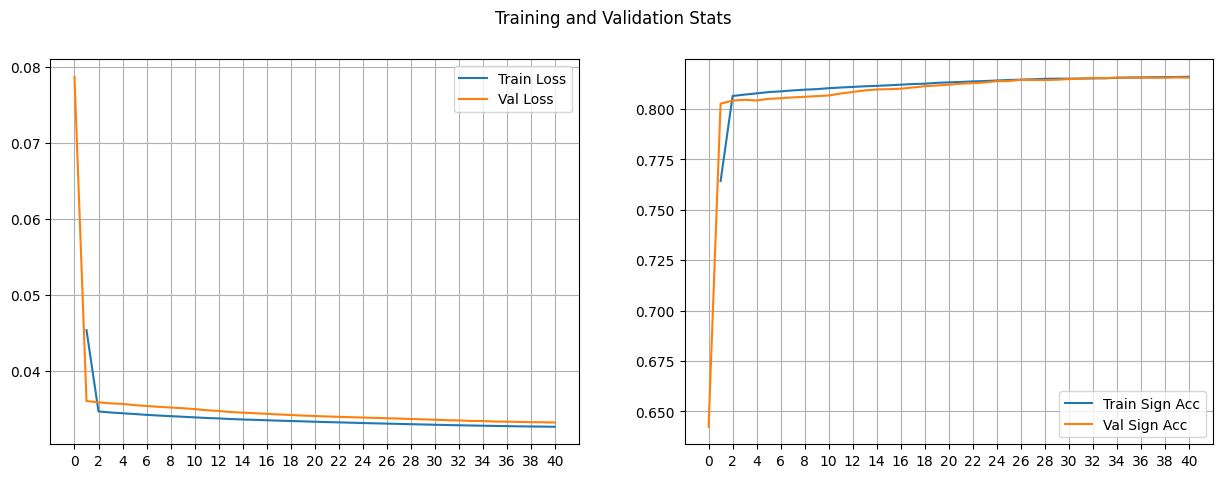

In [91]:
fig, (loss_plt, acc_plt) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'Training and Validation Stats')

loss_plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train Loss')
loss_plt.plot(val_loss, label='Val Loss')
loss_plt.legend()
loss_plt.grid()
loss_plt.set_xticks(np.arange(0, len(train_loss)+1, step=2))

#on the same graph plot accuracy but with independent y axis
acc_plt.plot(np.arange(1, len(train_sign_acc)+1), train_sign_acc, label='Train Sign Acc')
acc_plt.plot(val_sign_acc, label='Val Sign Acc')
acc_plt.legend()
acc_plt.grid()
acc_plt.set_xticks(np.arange(0, len(train_sign_acc)+1, step=2))

fig.show()

### Test + Metrics

In [92]:
if not use_lstm_prediction:
    @torch.no_grad()
    def get_test_metrics(model, model_mlp, edge_weight_model, X_test, y_test, edge_conn_test, edge_weight_test, device):
        model.eval()
        model_mlp.eval()
        if use_temporal:
            lstm.eval()

        if graph_weight_type == 'learnable correlation':
            edge_weight_model.eval()
        
        total_sign_acc = 0
        test_loss = 0
        num_samples = 0
        for xi, yi, edge_conn_test_i, edge_weight_test_i in zip(X_test, y_test, edge_conn_test, edge_weight_test):
            edge_weight_test_i = torch.tensor(edge_weight_test_i, dtype=torch.float, device=device)  # Convert list to tensor
            if graph_weight_type == 'learnable correlation':
                edge_weight_test_i = edge_weight_model(edge_weight_test_i.unsqueeze(-1)).squeeze(-1)  # Batch process edge weights

            edge_conn_tensor = torch.tensor(edge_conn_test_i, dtype=torch.long, device=device).t().contiguous()

            if edge_conn_tensor.size(0) == 0 or edge_weight_test_i.size(0) == 0:
                continue

            xi = torch.tensor(xi, dtype=torch.float, device=device)
            yi = torch.tensor(yi, dtype=torch.float, device=device)

            if use_temporal:
                xi = lstm(xi)

            out = model(xi, edge_conn_tensor, edge_weight=edge_weight_test_i)
            out = model_mlp(out).squeeze()

            mask = ~torch.isnan(yi)
            correct_sign = (out[mask] * yi[mask] > 0).sum().item()
            total_sign_acc += correct_sign
            num_samples += mask.sum().item()
            loss = criterion(out[mask], yi[mask])
            test_loss += loss.item()

        test_loss /= num_samples
        total_sign_acc /= num_samples
        return test_loss, total_sign_acc

    test_loss, sign_accuracy = get_test_metrics(
        model,
        model_mlp,
        edge_weight_model if graph_weight_type == 'learnable correlation' else None,
        X_test,
        y_test,
        edges_conn_test,
        edges_weight_test,
        device,
    )
    print(f'Test Loss: {round(test_loss, 8)}, Sign Accuracy: {round(sign_accuracy, 8)}')
else:
    @torch.no_grad()
    def get_test_metrics_lstm(lstm, criterion, device, X_test=X_test, y_test=y_test):
        lstm.eval()
        total_loss = 0
        total_sign_acc = 0
        num_samples = 0
        for xi, yi in zip(X_test, y_test):
            xi = torch.tensor(xi, dtype=torch.float, device=device)
            out = lstm(xi)
            out = out.squeeze()

            yi = torch.tensor(yi, dtype=torch.float, device=device)
            mask = ~torch.isnan(yi)
            loss = criterion(out[mask], yi[mask])
            total_loss += loss.item()
            total_sign_acc += (out[mask] * yi[mask] > 0).sum().item()
            num_samples += mask.sum().item()

        return total_loss / num_samples, total_sign_acc / num_samples

    test_loss, sign_accuracy = get_test_metrics_lstm(lstm, criterion_lstm, device)
    print(f'Test Loss: {round(test_loss, 8)}, Sign Accuracy: {round(sign_accuracy, 8)}')

Test Loss: 0.02875368, Sign Accuracy: 0.81692048


In [64]:
index = 1
logs = {
    "test_loss": test_loss,
    "test_sign_accuracy": sign_accuracy,
    "train_loss_hist": train_loss,
    "val_loss_hist": val_loss,
    "train_sign_accuracy_hist": train_sign_acc,
    "val_sign_accuracy_hist": val_sign_acc,
}

import json
from os.path import join as pjoin

if not os.path.exists('exp_logs'):
    os.makedirs('exp_logs')

with open(
    pjoin(
        'exp_logs',
        f'approach_{approach}__window_{window}'
        + (f'__use_attention' if use_attention else '')
        + (f'__use_temporal' if use_temporal else '')
        + (f'__use_lstm_prediction' if use_lstm_prediction else '')
        + (f'__use_learnable_correlation' if graph_weight_type == 'learnable correlation' else '')
        + (f'__run_index_{index}')
        + '.json'
    ), 'w'
) as f:
    json.dump(logs, f)